<a href="https://colab.research.google.com/github/eshaanagarwal/Word2Vec-Word-Embedding-/blob/main/Task_Word_Emeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Word Embeddings 
**Word2Vec with One hot encoding vectors(CBOG) using Softmax Activation 
function,Cross-Entropy loss function and Adam optimizer**

Technologies used - **Keras and TensorFlow and Numpy**


Dataset from IMDB Movie Review Datset of Stanford 

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2021-05-05 10:44:58--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  24.6MB/s    in 3.5s    

2021-05-05 10:45:02 (23.1 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [ ]:
!tar -xf aclImdb_v1.tar.gz

In [ ]:
cd aclImdb

/content/aclImdb


In [ ]:
import os
from tqdm import tqdm

Merging all The text files to single text file 

In [ ]:
outf = open('data.txt','w+')
outf.write('content\n')
for filename in tqdm(os.listdir('test/pos')):
    inpf = open('test/pos/'+filename,'r')
    inpstr = inpf.read()
    inpf.close()
    outf.write(inpstr+'\n')
for filename in tqdm(os.listdir('test/neg')):
    inpf = open('test/neg/'+filename,'r')
    inpstr = inpf.read()
    inpf.close()
    outf.write(inpstr+'\n')
outf.close()

100%|██████████| 12500/12500 [00:00<00:00, 41014.70it/s]


Text Processing Functions and Word Dictionary Function

In [ ]:
import itertools
import pandas as pd
import re
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.models import Input, Model
from keras.layers import Dense
from scipy import sparse

#Function to create unique dictionary
def create_unique_word_dict(text:list) -> dict:
  words = list(set(text))
  words.sort()
  
  unique_word_dict = {}
  for i, word in enumerate(words):
    unique_word_dict.update({
        word: i
        })
  
  return unique_word_dict    

# Function to clean the text and create the corpus
def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will','am', 'are', 'to', 'on', 'because', 'since']
    )->list:
    
  for x in text.lower(): 
      if x in punctuations: 
          text = text.replace(x, "  ")

    # Removing words that have numbers in them
  text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
  text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
  text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
  text = text.lower()

    # Converting all our text to a list 
  text = text.split(' ')

    # Droping empty strings
  text = [x for x in text if x!='']

    # Droping stop words
  text = [x for x in text if x not in stop_words]

  return text





 

Reading data through Pandas 

In [ ]:
pd.read_csv('data.txt',sep='\n')['content']

0        Wow.this is a touching story! First i saw 'Res...
1        Im a huge M Lillard fan that's why I ended up ...
2        From the offset, I knew this was going to be a...
3        Turning Isherwood's somewhat dark and utterly ...
4        Lang does Hawks as well as Hawks does in the f...
                               ...                        
24995    I know this movie is a low-budget horror movie...
24996    I walked into Blockbuster, itchin' to watch so...
24997    Any of Law & Order's, CSI (take your choice of...
24998    I don't want to seem too much of a nitpicky sp...
24999    Absolutely horrible movie. Not a bad plot conc...
Name: content, Length: 25000, dtype: object

Preprocessing of Text

In [ ]:
# Reading the text from the dataset
texts = pd.read_csv('data.txt', sep='\n')
texts = [x for x in texts['content'][:500]]

#  window for context words
window = 2


word_lists = []
all_text = []

for text in texts:

    # Preprocessing the text
  text = text_preprocessing(text)

    # Creating list with all the preprocessed text
  if text is not None:
    all_text += text 

    # Creating a context dictionary
  for i, word in enumerate(text):
      for w in range(window):
            
          if i + 1 + w < len(text): 
              word_lists.append([word] + [text[(i + 1 + w)]])
               
          if i - w - 1 >= 0:
              word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words from the dictionary 
words = list(unique_word_dict.keys())


Using Data Generator of Keras for supplying data to Neural Network

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):

    def __init__(self, word_list, unique_word_dict, batch_size=64,
                 n_classes=10, shuffle=True):
      
        self.word_list = word_list
        self.unique_word_dict = unique_word_dict
        self.n_words = len(unique_word_dict)
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.word_list) / self.batch_size))

    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        X = np.zeros((self.batch_size,self.n_words),dtype=np.float32)
        y = np.zeros((self.batch_size,self.n_words),dtype=np.float32)
        for i, k in enumerate(indexes):
            main_word_index = self.unique_word_dict.get(self.word_list[k][0])
            context_word_index = unique_word_dict.get(self.word_list[k][1])

            # One hot encoding the main word
            X[i,main_word_index] = 1

            # One hot encoding the Y matrix words 
            y[i,context_word_index] = 1
        #X = sparse.csr_matrix(X)
        #y = sparse.csr_matrix(y)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.word_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [ ]:
# Creating the X and Y matrices using one hot encoding
# X = []
# Y = []

# for i, word_list in tqdm(enumerate(word_lists)):
#     # Getting the indices
#   main_word_index = unique_word_dict.get(word_list[0])
#   context_word_index = unique_word_dict.get(word_list[1])

      
#   X_row = np.zeros(n_words)
#   Y_row = np.zeros(n_words)

#     # One hot encoding the main word
#   X_row[main_word_index] = 1

#     # One hot encoding the Y matrix words 
#   Y_row[context_word_index] = 1

    
#   X.append(X_row)
#   Y.append(Y_row)


In [ ]:
txtdata = DataGenerator(word_lists,unique_word_dict,batch_size=400)

Intializing and Training of  the network 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
959/959 [==============================] - 98s 99ms/step - loss: 8.8650
Epoch 2/50
959/959 [==============================] - 97s 99ms/step - loss: 7.3390
Epoch 3/50
959/959 [==============================] - 97s 100ms/step - loss: 7.3036
Epoch 4/50
959/959 [==============================] - 97s 99ms/step - loss: 7.2906
Epoch 5/50
959/959 [==============================] - 96s 99ms/step - loss: 7.2895
Epoch 6/50
959/959 [==============================] - 97s 99ms/step - loss: 7.2842
Epoch 7/50
959/959 [==============================] - 96s 98ms/step - loss: 7.2842
Epoch 8/50
959/959 [==============================] - 97s 99ms/step - loss: 7.2749
Epoch 9/50
959/959 [==============================] - 97s 99ms/step - loss: 7.2690
Epoch 10/50
959/959 [==============================] - 97s 99ms/step - loss: 7.2683
Epoch 11/50
959/959 [==============================] - 97s 99ms/step - loss: 7.2663
Epoch 12/50
959/959 [==============================] - 97s 98ms/step - loss: 7.2649


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags

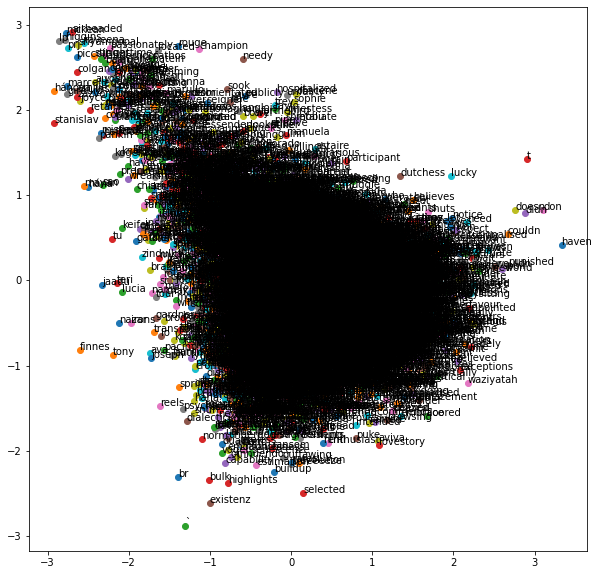

In [ ]:
# Converting the matrices into a sparse format using sparse function from scipy
 
# Defining the size of the embedding
embed_size = 2
 
# Defining the neural network of our model
inp = Input(shape=(n_words,))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=n_words, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
 
# Optimizing the network weights
model.fit_generator(
    generator=txtdata,
    epochs=50,
    use_multiprocessing=True,
    workers=10
    )
 
 
 
# The input layer 
weights = model.get_weights()[0]
 
# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words:
  embedding_dict.update({
      word: weights[unique_word_dict.get(word)]
        })
 
# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
  coord = embedding_dict.get(word)
  plt.scatter(coord[0], coord[1])
  plt.annotate(word, (coord[0], coord[1]))

# Output -
 
 
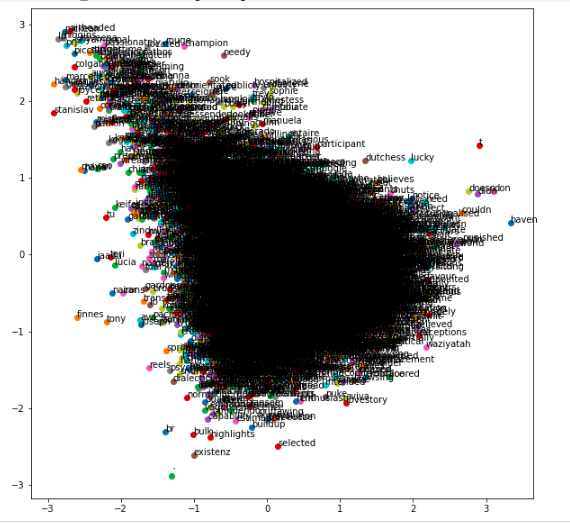